# Acidentes em Recife (2021 - 2023)

## O que vamos analisar?
Neste documento analisaremos a evolução dos acidentes em alguns pontos estratégicos da cidade do Recife no período entre 2021 e 2023

## Por que faremos esta análise?
É de saber comum que desde Junho de 2023 a cidade do Recife está sem radares de velocidade eletrônicos em alguns pontos, já que a licitação destes equipamentos venceu nesta época. Sendo assim, é pertinente sabermos se houve algum aumento no número de acidentes e/ou vítimas nos principais trechos sem fiscalização

## A quem interessa esta análise?
A todos que residem no Recife e aos que não residem também, já que podemos trazer de forma analítica a importância de haver fiscalização de velocidade em avenidas de grandes cidades

## O que podemos esperar em 2024?
Com base nas análises realizadas, foi feito um modelo SARIMAX para que possamos, baseado na média histórica, projetarmos a quantidade de veículos envolvidos em acidentes e a quantidade de vítimas

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1. Importando dados

In [3]:
acidentes2021 = pd.read_csv("acidentes2021.csv", delimiter = ";")
acidentes2022 = pd.read_csv("acidentes2022.csv", delimiter = ";")
acidentes2023 = pd.read_csv("acidentes2023.csv", delimiter = ";")

# 2. Concatenando arquivos e verificando dados

In [4]:
acidentes = pd.concat([acidentes2021, acidentes2022, acidentes2023], axis = 0)

In [5]:
acidentes.shape

(9081, 39)

In [6]:
acidentes.dtypes

data                         object
hora                         object
natureza_acidente            object
situacao                     object
bairro                       object
endereco                     object
numero                       object
detalhe_endereco_acidente    object
complemento                  object
bairro_cruzamento            object
num_semaforo                 object
sentido_via                  object
tipo                         object
auto                         object
moto                         object
ciclom                       object
ciclista                     object
pedestre                     object
onibus                       object
caminhao                     object
viatura                      object
outros                       object
vitimas                      object
vitimasfatais                object
acidente_verificado          object
tempo_clima                  object
situacao_semaforo            object
sinalizacao                 

In [7]:
acidentes.ciclom.value_counts()

0,0    6677
0      2361
1,0      24
1        19
Name: ciclom, dtype: int64

# 3. Convertendo dados

In [8]:
acidentes["data"] = pd.to_datetime(acidentes["data"], errors = "coerce")
acidentes["hora"] = pd.to_datetime(acidentes["hora"], format = "%H:%M:%S", errors = "coerce").dt.time

In [9]:
def converter_para_num(df):
    colunas_para_converter = ["auto", "moto", "ciclom", "ciclista", "pedestre", "onibus", "caminhao", "viatura",
                              "outros", "vitimas", "vitimasfatais"]
    for coluna in colunas_para_converter:
        if coluna in df.columns:
            df[coluna] = df[coluna].astype(str).str.replace(",", ".")
            df[coluna] = pd.to_numeric(df[coluna], errors='coerce')
    return df

In [10]:
acidentes = converter_para_num(acidentes)

In [11]:
acidentes.head()

,data,hora,natureza_acidente,situacao,bairro,endereco,numero,detalhe_endereco_acidente,complemento,bairro_cruzamento,...,conservacao_via,ponto_controle,situacao_placa,velocidade_max_via,mao_direcao,divisao_via1,divisao_via2,divisao_via3,Protocolo,natureza
0,2021-01-01,19:44:00,COM VÍTIMA,FINALIZADA,MADALENA,RUA BENFICA,NaN,NaN,EM FRENTE AO EXTRA NA SAIDA,MADALENA,...,Perfeito estado,Outros,Não há placas,NaN,Dupla,Faixa contínua,Faixa seccionada,NaN,NaN,NaN
1,2021-01-01,23:15:40,COM VÍTIMA,FINALIZADA,VÁRZEA,AV CAXANGA,NaN,RUA GASTAO VIDIGAL,EM FRENTE A UPA DA CAXANGA,VÁRZEA,...,Perfeito estado,Outros,Outras,NaN,Única,Não existe,NaN,NaN,NaN,NaN
2,2021-01-02,10:54:00,COM VÍTIMA,FINALIZADA,VASCO DA GAMA,RUA RESPLENDOR,353,NaN,AO LADO DO COLEGIO ADERBAL GALVÃO EM FRE...,VASCO DA GAMA,...,Perfeito estado,Não existe,Não há placas,NaN,Dupla,Não existe,NaN,NaN,NaN,NaN
3,2021-01-02,11:13:00,COM VÍTIMA,FINALIZADA,BOA VIAGEM,RUA VISCONDE DE JEQUITINHONHA,22,RUA CAPITAO ZUZINHA,RUA CAPITÃO ZUZINHA,BOA VIAGEM,...,Perfeito estado,Faixa de pedestre,Outras,NaN,Única,Canal,NaN,NaN,NaN,NaN
4,2021-01-03,09:32:00,COM VÍTIMA,FINALIZADA,ILHA DO RETIRO,AV ENGENHEIRO ABDIAS DE CARVALHO,365,NaN,EM FRENTE A LANCHONETE COXINHAS DE BATATA,ILHA DO RETIRO,...,Perfeito estado,Faixa de pedestre,Outras,60 km/h,Dupla,Faixa contínua,Faixa seccionada,Canteiro central,NaN,NaN


# 4. Selecionando Localidades de Análise

In [12]:
acidentes_jose_estelita = acidentes.loc[acidentes.endereco == "AV ENGENHEIRO JOSE ESTELITA"]
acidentes_capitao_temudo = acidentes.loc[acidentes.endereco == "VIADUTO CAPITAO TEMUDO"]
acidentes_paulo_guerra = acidentes.loc[acidentes.endereco == "PTE PAULO GUERRA"]
acidentes_via_mangue = acidentes.loc[acidentes.endereco == "AVENIDA CELSO FURTADO (VIA MANGUE)"]
acidentes_mascarenhas = acidentes.loc[acidentes.endereco == "AV MARECHAL MASCARENHAS DE MORAES"]

acidentes_filtrados = pd.concat([acidentes_jose_estelita, acidentes_capitao_temudo, 
                                 acidentes_paulo_guerra, acidentes_via_mangue, acidentes_mascarenhas]).copy()
acidentes_filtrados.head()

,data,hora,natureza_acidente,situacao,bairro,endereco,numero,detalhe_endereco_acidente,complemento,bairro_cruzamento,...,conservacao_via,ponto_controle,situacao_placa,velocidade_max_via,mao_direcao,divisao_via1,divisao_via2,divisao_via3,Protocolo,natureza
84,2021-01-15,17:02:00,COM VÍTIMA,FINALIZADA,SÃO JOSÉ,AV ENGENHEIRO JOSE ESTELITA,NaN,NaN,ANTES DO VIADUTO CAPITÃO TEMUDO,SÃO JOSÉ,...,Perfeito estado,Faixa de pedestre,NaN,NaN,Dupla,Canteiro central,NaN,NaN,NaN,NaN
130,2021-01-21,10:36:00,COM VÍTIMA,FINALIZADA,CABANGA,AV ENGENHEIRO JOSE ESTELITA,NaN,NaN,EMBAIXO DO VIADUTO DO CABANGA,CABANGA,...,Perfeito estado,Não existe,Não há placas,NaN,Única,Não existe,NaN,NaN,NaN,NaN
173,2021-01-27,08:55:00,SEM VÍTIMA,FINALIZADA,CABANGA,AV ENGENHEIRO JOSE ESTELITA,S/N,PRC GOVERNADOR PAULO GUERRA,AO LADO DO CABANGA IATE CLUB - PISTA OESTE SEN...,CABANGA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201,2021-01-30,15:07:00,COM VÍTIMA,CANCELADA,CABANGA,AV ENGENHEIRO JOSE ESTELITA,NaN,NaN,E/F AO CAMBANGA IATE CLUBE S/T CID,CABANGA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1153,2021-07-06,13:34:00,COM VÍTIMA,FINALIZADA,SÃO JOSÉ,AV ENGENHEIRO JOSE ESTELITA,NaN,NaN,EM FRENTE AO EDF. MIRANTE DO CAIS,SÃO JOSÉ,...,Perfeito estado,Não existe,Não há placas,60 km/h,Única,Faixa seccionada,NaN,NaN,NaN,NaN


# 5. Dropando colunas

In [13]:
dropar_colunas = [
    'natureza_acidente', 'situacao', 'numero', 'detalhe_endereco_acidente', 
    'complemento', 'bairro_cruzamento', 'conservacao_via', 'ponto_controle', 
    'situacao_placa', 'velocidade_max_via', 'mao_direcao', 'divisao_via1', 
    'divisao_via2', 'divisao_via3', 'Protocolo', "num_semaforo", "sentido_via",
    "acidente_verificado", "situacao_semaforo"
]

In [14]:
print(acidentes_filtrados.columns)

Index(['data', 'hora', 'natureza_acidente', 'situacao', 'bairro', 'endereco',
       'numero', 'detalhe_endereco_acidente', 'complemento',
       'bairro_cruzamento', 'num_semaforo', 'sentido_via', 'tipo', 'auto',
       'moto', 'ciclom', 'ciclista', 'pedestre', 'onibus', 'caminhao',
       'viatura', 'outros', 'vitimas', 'vitimasfatais', 'acidente_verificado',
       'tempo_clima', 'situacao_semaforo', 'sinalizacao', 'condicao_via',
       'conservacao_via', 'ponto_controle', 'situacao_placa',
       'velocidade_max_via', 'mao_direcao', 'divisao_via1', 'divisao_via2',
       'divisao_via3', 'Protocolo', 'natureza'],
      dtype='object')


In [15]:
acidentes_filtrados.drop(columns = dropar_colunas, axis=1, inplace=True)
acidentes_filtrados.head()

,data,hora,bairro,endereco,tipo,auto,moto,ciclom,ciclista,pedestre,onibus,caminhao,viatura,outros,vitimas,vitimasfatais,tempo_clima,sinalizacao,condicao_via,natureza
84,2021-01-15,17:02:00,SÃO JOSÉ,AV ENGENHEIRO JOSE ESTELITA,COLISÃO TRANSVERSAL,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,Bom,Perfeito estado,Seca,NaN
130,2021-01-21,10:36:00,CABANGA,AV ENGENHEIRO JOSE ESTELITA,COLISÃO LATERAL,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Bom,Perfeito estado,Seca,NaN
173,2021-01-27,08:55:00,CABANGA,AV ENGENHEIRO JOSE ESTELITA,COLISÃO TRASEIRA,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
201,2021-01-30,15:07:00,CABANGA,AV ENGENHEIRO JOSE ESTELITA,COLISÃO,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN
1153,2021-07-06,13:34:00,SÃO JOSÉ,AV ENGENHEIRO JOSE ESTELITA,COLISÃO TRASEIRA,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Bom,Incompleta,Seca,NaN


# 6. Preenchendo Valores Nulos

In [16]:
acidentes_filtrados.isnull().sum()

data               0
hora             126
bairro             0
endereco           0
tipo              12
auto               0
moto               0
ciclom             0
ciclista           0
pedestre           0
onibus             0
caminhao           0
viatura            0
outros             0
vitimas            0
vitimasfatais      0
tempo_clima      302
sinalizacao      306
condicao_via     303
natureza          91
dtype: int64

In [17]:
def preencher_valores_nulos(df):
    for coluna in df.columns:
        if coluna not in ["hora", "tipo", "tempo_clima", "sinalizacao", "condicao_via", "natureza"]:
            df[coluna].fillna(0, inplace=True)
        else:
            df[coluna].fillna("Não informado", inplace=True)
    return df

In [18]:
acidentes_filtrados = preencher_valores_nulos(acidentes_filtrados)

In [19]:
acidentes_filtrados.isnull().sum()

data             0
hora             0
bairro           0
endereco         0
tipo             0
auto             0
moto             0
ciclom           0
ciclista         0
pedestre         0
onibus           0
caminhao         0
viatura          0
outros           0
vitimas          0
vitimasfatais    0
tempo_clima      0
sinalizacao      0
condicao_via     0
natureza         0
dtype: int64

# 7. Verificando medidas estatísticas principais

In [20]:
round(acidentes_filtrados.describe(), 3)

,auto,moto,ciclom,ciclista,pedestre,onibus,caminhao,viatura,outros,vitimas,vitimasfatais
count,463.000,463.000,463.000,463.000,463.000,463.000,463.000,463.000,463.000,463.000,463.000
mean,0.715,0.724,0.004,0.048,0.048,0.052,0.054,0.043,0.004,0.920,0.013
std,0.681,0.552,0.066,0.242,0.232,0.231,0.226,0.204,0.066,0.581,0.113
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
50%,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
75%,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
max,4.000,3.000,1.000,3.000,2.000,2.000,1.000,1.000,1.000,4.000,1.000


In [21]:
acidentes_filtrados.shape

(463, 20)

# 8. Agregando dados por mês

In [22]:
acidentes_filtrados['total_automoveis'] = (
    acidentes_filtrados['auto'] + 
    acidentes_filtrados['moto'] + 
    acidentes_filtrados['ciclom'] + 
    acidentes_filtrados['caminhao'] + 
    acidentes_filtrados['onibus'] + 
    acidentes_filtrados['viatura'] + 
    acidentes_filtrados['outros']
)

In [23]:
acidentes_filtrados['mes'] = acidentes_filtrados['data'].dt.to_period('M')
acidentes_por_mes = acidentes_filtrados.groupby('mes').agg({'total_automoveis': 'sum', 'vitimas': 'sum', 'data': 'size'}).reset_index()

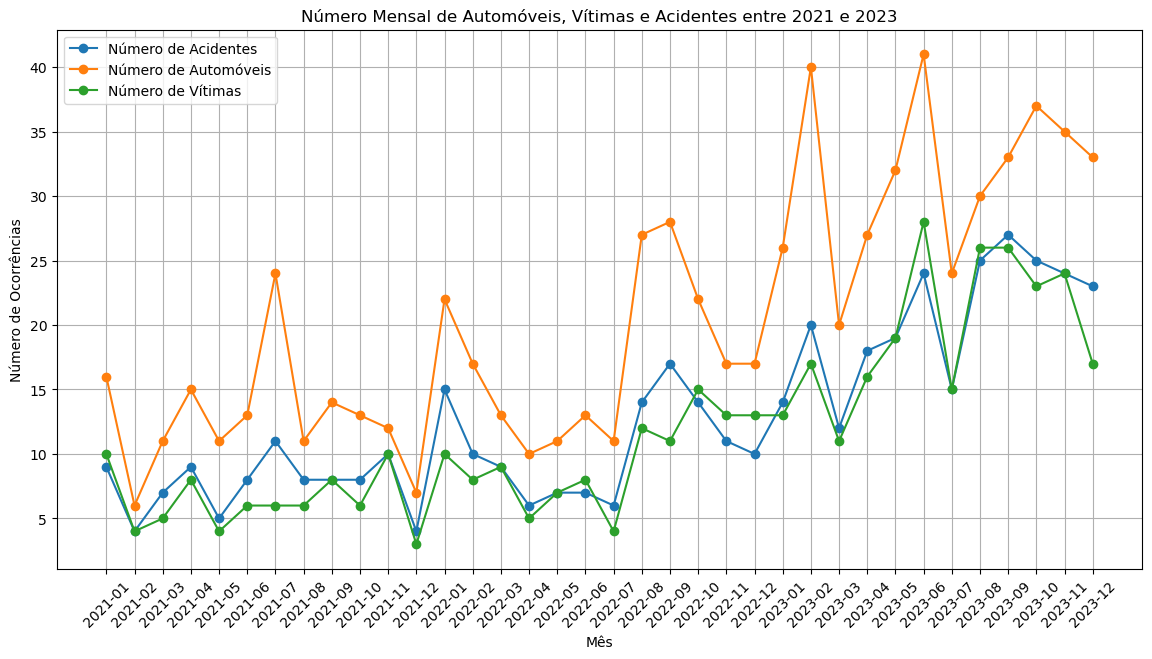

In [24]:
plt.figure(figsize=(14, 7))
plt.plot(acidentes_por_mes['mes'].astype(str), acidentes_por_mes['data'], label='Número de Acidentes',marker='o')
plt.plot(acidentes_por_mes['mes'].astype(str), acidentes_por_mes['total_automoveis'], label = "Número de Automóveis",marker='o')
plt.plot(acidentes_por_mes['mes'].astype(str), acidentes_por_mes['vitimas'], label='Número de Vítimas',marker='o')
plt.xlabel('Mês')
plt.ylabel('Número de Ocorrências')
plt.title('Número Mensal de Automóveis, Vítimas e Acidentes entre 2021 e 2023')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 9. Agregando dados por semestre

In [25]:
acidentes_filtrados['semestre'] = (acidentes_filtrados['data'].dt.month - 1) // 6 + 1
acidentes_filtrados['ano_semestre'] = acidentes_filtrados['data'].dt.year.astype(str) + 'S' + acidentes_filtrados['semestre'].astype(str)
acidentes_semestrais = acidentes_filtrados.groupby('ano_semestre').agg({'total_automoveis': 'sum', 
                                                                        'vitimas': 'sum', 
                                                                        'data': 'size'}).reset_index()

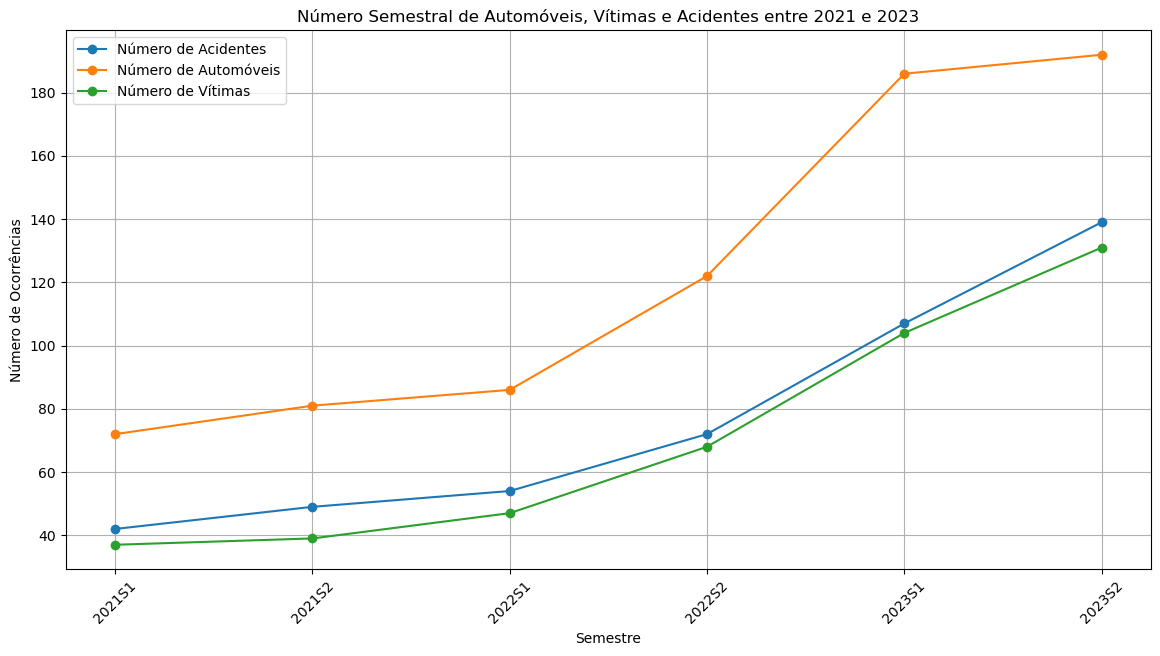

In [26]:
plt.figure(figsize=(14, 7))
plt.plot(acidentes_semestrais['ano_semestre'].astype(str), acidentes_semestrais['data'], label='Número de Acidentes', marker='o')
plt.plot(acidentes_semestrais['ano_semestre'].astype(str), acidentes_semestrais['total_automoveis'], label = "Número de Automóveis", marker='o')
plt.plot(acidentes_semestrais['ano_semestre'].astype(str), acidentes_semestrais['vitimas'], label='Número de Vítimas', marker='o')
plt.xlabel('Semestre')
plt.ylabel('Número de Ocorrências')
plt.title('Número Semestral de Automóveis, Vítimas e Acidentes entre 2021 e 2023')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 10. Criação do modelo preditivo

C:\Users\luizs\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\luizs\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\luizs\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


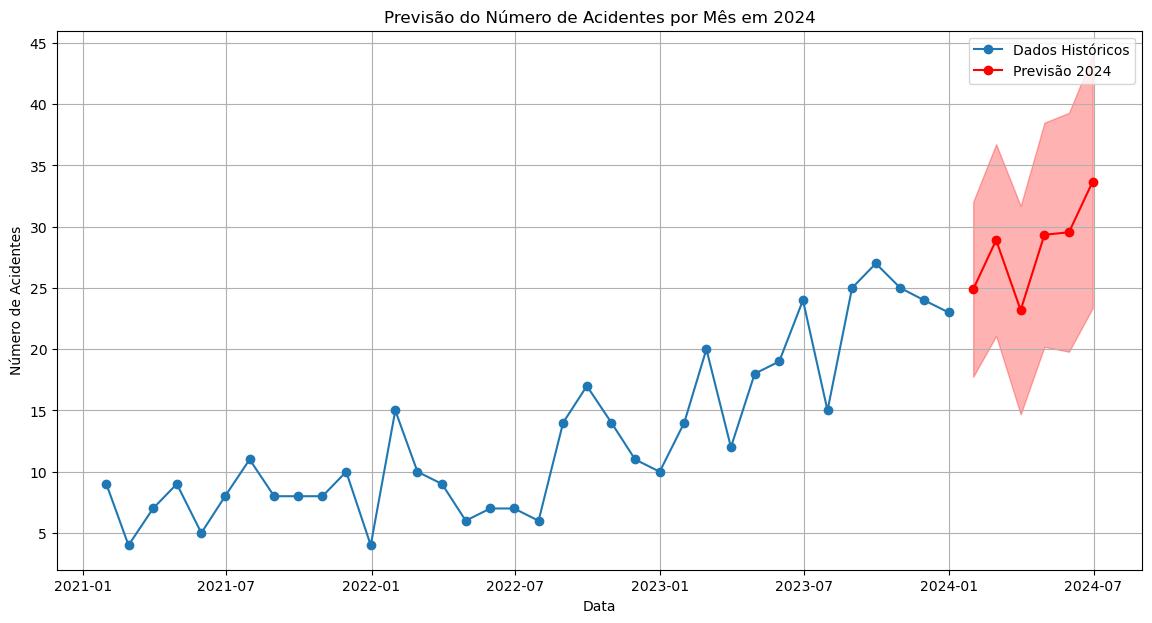

In [37]:
acidentes_mensais = acidentes_filtrados.resample('M', on='data').size().reset_index(name='num_acidentes')

serie_temporal_mensal = acidentes_mensais.set_index('data')['num_acidentes']

# Ajustar o modelo SARIMA
modelo = SARIMAX(serie_temporal_mensal, 
                 order=(1, 1, 1),  
                 seasonal_order=(1, 0, 1, 12),
                 enforce_stationarity=False, 
                 enforce_invertibility=False)

resultado = modelo.fit()

previsao = resultado.get_forecast(steps=6)
previsao_mean = previsao.predicted_mean
previsao_conf_int = previsao.conf_int()

# Criar um DataFrame com as previsões
previsoes_2024 = previsao_mean.reset_index()
previsoes_2024.columns = ['data', 'previsao_acidentes']

# Adicionar intervalos de confiança
previsoes_2024['lower_ci'] = previsao_conf_int.iloc[:, 0].values
previsoes_2024['upper_ci'] = previsao_conf_int.iloc[:, 1].values

# Visualizar as previsões
plt.figure(figsize=(14, 7))
plt.plot(serie_temporal_mensal.index, serie_temporal_mensal, label='Dados Históricos', marker='o')
plt.plot(previsoes_2024['data'], previsoes_2024['previsao_acidentes'], label='Previsão 2024', marker='o', color='red')
plt.fill_between(previsoes_2024['data'], previsoes_2024['lower_ci'], previsoes_2024['upper_ci'], color='red', alpha=0.3)
plt.xlabel('Data')
plt.ylabel('Número de Acidentes')
plt.title('Previsão do Número de Acidentes por Mês em 2024')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
serie_temporal = acidentes_semestrais.set_index('ano_semestre')['total_automoveis']

C:\Users\luizs\AppData\Local\Temp\ipykernel_13440\1598446232.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  acidentes_mensais = acidentes_filtrados.resample('M', on='data').sum().reset_index()
C:\Users\luizs\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\luizs\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\luizs\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for var

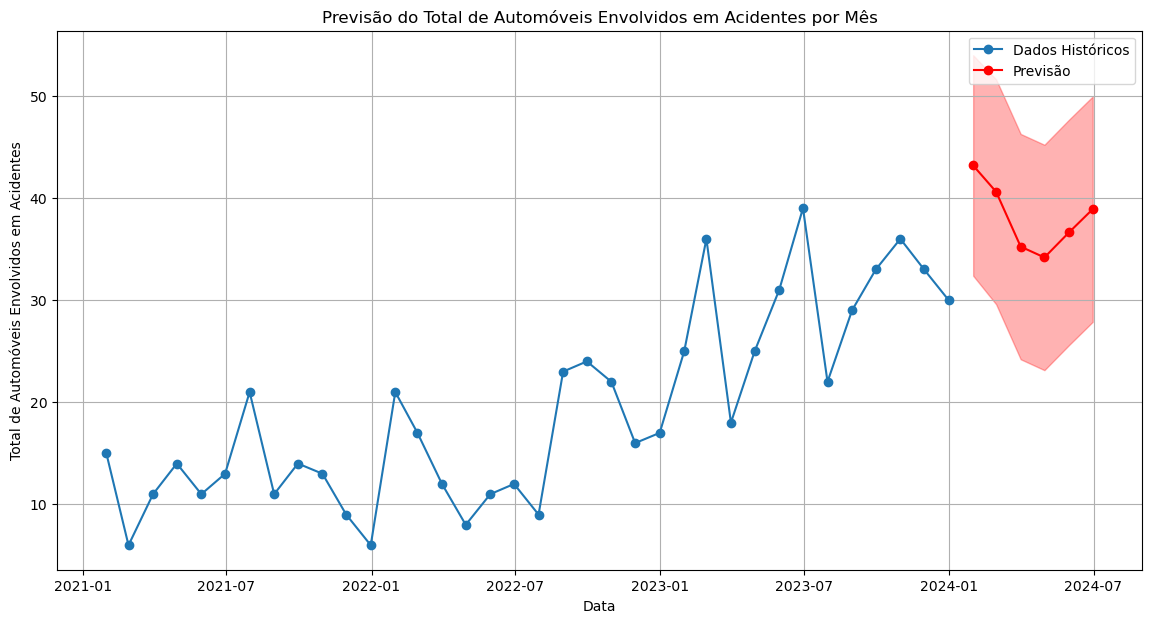

In [33]:
acidentes_mensais = acidentes_filtrados.resample('M', on='data').sum().reset_index()

# Selecionar apenas as colunas relevantes para a análise
acidentes_mensais['total_automoveis'] = (
    acidentes_mensais['auto'] + 
    acidentes_mensais['moto'] + 
    acidentes_mensais['caminhao'] + 
    acidentes_mensais['ciclom']
)

serie_temporal_mensal = acidentes_mensais.set_index('data')['total_automoveis']

# Ajustar o modelo SARIMA
modelo = SARIMAX(serie_temporal_mensal, 
                 order=(1, 1, 1),  
                 seasonal_order=(1, 1, 1, 12),
                 enforce_stationarity=False, 
                 enforce_invertibility=False)
resultado = modelo.fit()

previsao = resultado.get_forecast(steps=6)
previsao_mean = previsao.predicted_mean
previsao_conf_int = previsao.conf_int()

# Plotar o resultado
plt.figure(figsize=(14, 7))
plt.plot(serie_temporal_mensal.index, serie_temporal_mensal, label='Dados Históricos', marker='o')
plt.plot(previsao_mean.index, previsao_mean, label='Previsão', marker='o', color='red')
plt.fill_between(previsao_conf_int.index, previsao_conf_int.iloc[:, 0], previsao_conf_int.iloc[:, 1], color='red', alpha=0.3)
plt.xlabel('Data')
plt.ylabel('Total de Automóveis Envolvidos em Acidentes')
plt.title('Previsão do Total de Automóveis Envolvidos em Acidentes por Mês')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\luizs\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\luizs\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\luizs\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


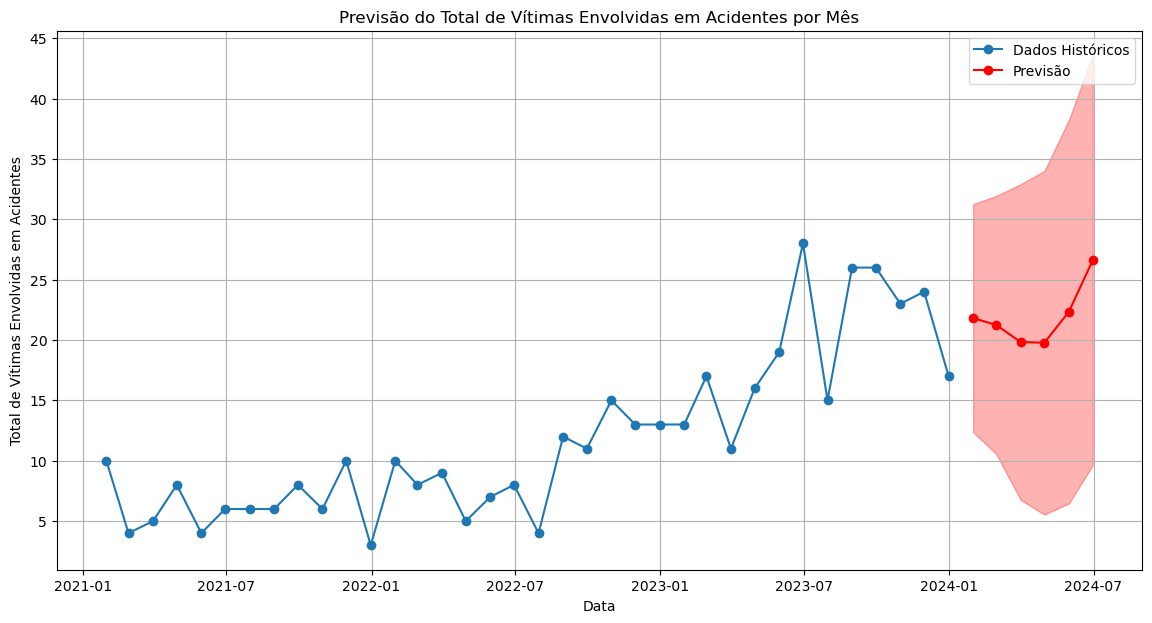

In [30]:
serie_temporal_mensal = acidentes_mensais.set_index('data')['vitimas']

# Ajustar o modelo SARIMA
modelo = SARIMAX(serie_temporal_mensal, 
                 order=(1, 1, 1),  
                 seasonal_order=(1, 1, 1, 12),
                 enforce_stationarity=False, 
                 enforce_invertibility=False)
resultado = modelo.fit()

previsao = resultado.get_forecast(steps=6)
previsao_mean = previsao.predicted_mean
previsao_conf_int = previsao.conf_int()

# Plotar o resultado
plt.figure(figsize=(14, 7))
plt.plot(serie_temporal_mensal.index, serie_temporal_mensal, label='Dados Históricos', marker='o')
plt.plot(previsao_mean.index, previsao_mean, label='Previsão', marker='o', color='red')
plt.fill_between(previsao_conf_int.index, previsao_conf_int.iloc[:, 0], previsao_conf_int.iloc[:, 1], color='red', alpha=0.3)
plt.xlabel('Data')
plt.ylabel('Total de Vítimas Envolvidas em Acidentes')
plt.title('Previsão do Total de Vítimas Envolvidas em Acidentes por Mês')
plt.legend()
plt.grid(True)
plt.show()